In [1]:
import ROOT as rt

Welcome to JupyROOT 6.12/07


In [2]:
%%bash 
ls /eos/uscms/store/group/lpcjme/noreplica/NanoHRT/Trees/Apr08/forMCComparions/reweighted/

BulkGravToZZ_tree.root
BulkGravTohh_tree.root
ZprimeToTT_tree.root
ZprimeToWW_tree.root
qcd-pythia_tree.root


In [26]:
file_hh = rt.TFile.Open('/eos/uscms/store/group/lpcjme/noreplica/NanoHRT/Trees/Apr08/forMCComparions/reweighted/BulkGravTohh_tree.root')
file_qcd = rt.TFile.Open('/eos/uscms/store/group/lpcjme/noreplica/NanoHRT/Trees/Apr08/forMCComparions/reweighted/qcd-pythia_tree.root')

In [27]:
tree_hh = file_hh.Get('Friends')
tree_qcd = file_qcd.Get('Friends')
tree_hh.Print()

******************************************************************************
*Tree    :Friends   : Friend tree for Events                                 *
*Entries :  1492191 : Total =       521149904 bytes  File  Size =  339214366 *
*        :          : Tree compression factor =   1.54                       *
******************************************************************************
*Br    0 :i_evt     : i_evt/I                                                *
*Entries :  1492191 : Total  Size=    5988829 bytes  File Size  =    3158342 *
*Baskets :      208 : Basket Size=      32000 bytes  Compression=   1.89     *
*............................................................................*
*Br    1 :i_parton  : i_parton/I                                             *
*Entries :  1492191 : Total  Size=    5989465 bytes  File Size  =     225766 *
*Baskets :      208 : Basket Size=      32000 bytes  Compression=  26.51     *
*...................................................

In [45]:
%jsroot on

# define tagger
tagger = 'ak8_nn_HbbvsQCD'
tagger = 'ak8_decorr_nn_ZHbbvsQCD'
tagger = 'ak8_doubleb'
tagger = 'ak8_tau21'
#tagger = 'ak8_ecfN2'
#tagger = 'ak8_bestH'

cuts = 'gen_pt > 1000 && gen_pt < 1500 && abs(gen_eta) < 2.4 && ak8_sdmass > 90 && ak8_sdmass < 140'

hist_hh = rt.TH1D('hist_hh','hist_hh',100,0,1)
hist_qcd = rt.TH1D('hist_qcd','hist_qcd',100,0,1)
tree_hh.Project('hist_hh',tagger,'rewgt*(%s)'%cuts)
tree_qcd.Project('hist_qcd',tagger,'genweight*(%s)'%cuts)

c = rt.TCanvas('c','c',500,400)
hist_hh.Scale(1/hist_hh.Integral())
hist_qcd.Scale(1/hist_qcd.Integral())
hist_qcd.SetLineColor(rt.kBlue)
hist_hh.SetLineColor(rt.kRed)
hist_qcd.Draw('h')
hist_hh.Draw('hsame')
hist_qcd.Draw('hsame')
c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: hist_hh (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_qcd (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [2]:
import uproot
!pip install lz4 --user
uptree_hh = uproot.open("/eos/uscms/store/group/lpcjme/noreplica/NanoHRT/Trees/Apr08/forMCComparions/reweighted/BulkGravTohh_tree.root")["Friends"]
uptree_qcd = uproot.open("/eos/uscms/store/group/lpcjme/noreplica/NanoHRT/Trees/Apr08/forMCComparions/reweighted/qcd-pythia_tree.root")["Friends"]

In [7]:
branches = ['ak8_nn_HbbvsQCD','ak8_decorr_nn_ZHbbvsQCD','ak8_doubleb','ak8_tau21','ak8_ecfN2','ak8_bestH','gen_pt','gen_eta','ak8_sdmass','ak8_pt']
df_hh = uptree_hh.pandas.df(branches=branches+['rewgt'])
df_qcd = uptree_qcd.pandas.df(branches=branches+['genweight'])

In [19]:
from sklearn.metrics import roc_curve, auc
import pandas
import numpy as np
df_hh['sample_weight'] = df_hh['rewgt']
df_hh['label'] = np.ones((len(df_hh)),dtype=int)
df_qcd['sample_weight'] = df_qcd['genweight']
df_qcd['label'] = np.zeros((len(df_qcd)),dtype=int)
df = pandas.concat([df_hh,df_qcd])

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [27]:
tagger = 'ak8_doubleb'
fpr = {}
tpr = {}
threshold = {}
fpr[tagger], tpr[tagger], threshold[tagger] = roc_curve(df['label'], df[tagger], sample_weight=df['sample_weight'])

[]

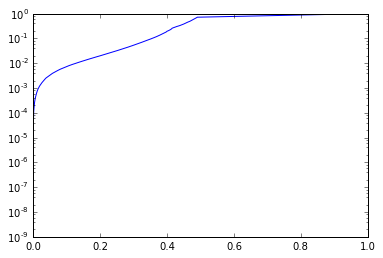

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(tpr[tagger],fpr[tagger],label='%s tagger'%tagger)
plt.semilogy()